In [1]:
import sys
sys.path.append("..")

import Essentials


In [2]:
import numpy as np

from sklearn.preprocessing import StandardScaler
import Essentials
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
from abc import ABC, abstractmethod

In [3]:
a = np.load('C:\\Users\\misha\\PLSSVD\\Data_Average.npz', allow_pickle=True)

In [4]:
x1 = a['X_test_1']
x2 = a['X_train_1']

y1 = a['Y_test_1']
y2 = a['Y_train_1']

In [5]:
timestamp1 = y1[:, 1]
timestamp2 = y2[:, 1]

y1 = y1[:, 0].reshape(len(y1), 1)
y1 = y1.astype(np.float64)
y2 = y2[:, 0].reshape(len(y2), 1)
y2 = y2.astype(np.float64)

C:\Users\misha\AppData\Local\Temp\ipykernel_8792\3146428066.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = y1.astype(np.float64)
C:\Users\misha\AppData\Local\Temp\ipykernel_8792\3146428066.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y2 = y2.astype(np.float64)


In [6]:
y1.shape

(74, 1)

In [7]:
x1.shape

(74, 96)

In [8]:

class PLSSVDSoftSensor(Essentials.SoftSensor):
    def __init__(self, name, x_train, y_train, n_components=2):
        super().__init__(name)
        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
        self.train(x_train, y_train, n_components)

    def preprocessing(self, x):
        return self.x_scaler.transform(x)

    def postprocessing(self, y):
        return self.y_scaler.inverse_transform(y)

    def evaluate_model(self, x):
        return self.get_model().predict(x)

    def train(self, x_train, y_train, n_components=2):
        x_train_scaled = self.x_scaler.fit_transform(x_train)
        y_train_scaled = self.y_scaler.fit_transform(y_train)
        
        # Поиск оптимального количества компонентов
        best_score = -np.inf
        best_n_components = 0
        for i in range(1, n_components + 1):
            model = PLSRegression(n_components=i)
            scores = cross_val_score(model, x_train_scaled, y_train_scaled, cv=5, scoring='r2')
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_n_components = i
        
        # Обучение модели
        self.set_model(PLSRegression(n_components=best_n_components))
        self.get_model().fit(x_train_scaled, y_train_scaled)
        self.coefficients = self.get_model().coef_
        self.n_components = best_n_components
        self.best_cv_score = best_score

    def __str__(self):
        coefs_str = ", ".join([f"{coef:.3f}" for coef in self.coefficients.ravel()])
        return (f"Модель PLSSVD с {self.n_components} компонентами.\n"
                f"Коэффициенты регрессии: {coefs_str}\n"
                f"Средний R^2 на кросс-валидации: {self.best_cv_score:.3f}")

In [9]:
# Пример создания экземпляра класса PLSSVDSoftSensor
Test_sensor_2 = PLSSVDSoftSensor(name="PLSSVD Sensor", x_train=x1, y_train=y1)

In [10]:
Test_sensor_1 = PLSSVDSoftSensor(name="PLSSVD Sensor", x_train=x2, y_train=y2)

In [11]:
print(Test_sensor_1)

Модель PLSSVD с 2 компонентами.
Коэффициенты регрессии: 0.024, 0.011, -0.023, 0.013, 0.015, -0.008, 0.001, 0.013, -0.016, 0.006, 0.013, -0.022, 0.032, 0.007, 0.025, 0.009, 0.021, 0.018, -0.034, -0.014, -0.003, -0.039, 0.032, 0.033, 0.000, 0.033, -0.040, 0.020, -0.061, -0.028, -0.019, 0.003, 0.009, 0.024, -0.015, 0.034, -0.048, 0.033, 0.011, -0.027, -0.027, -0.012, 0.011, 0.023, 0.018, 0.007, 0.008, 0.023, 0.016, 0.015, 0.014, 0.016, 0.019, 0.016, 0.019, 0.017, 0.021, -0.021, 0.056, 0.009, 0.007, 0.013, -0.016, 0.003, -0.018, 0.040, -0.030, -0.008, -0.013, 0.017, 0.040, 0.005, -0.003, -0.032, -0.026, -0.004, -0.004, -0.010, 0.009, 0.003, 0.029, 0.043, 0.027, -0.034, 0.011, 0.022, 0.021, -0.002, 0.013, 0.024, -0.012, -0.011, 0.030, -0.011, 0.014, 0.020
Средний R^2 на кросс-валидации: 0.038


In [12]:
print(Test_sensor_2)

Модель PLSSVD с 1 компонентами.
Коэффициенты регрессии: 0.018, -0.047, 0.020, 0.022, -0.000, 0.039, 0.035, 0.020, -0.028, 0.018, 0.020, -0.035, 0.040, 0.010, 0.013, 0.020, 0.051, 0.046, -0.019, 0.003, -0.006, -0.010, 0.039, 0.011, 0.023, 0.006, -0.062, -0.000, -0.054, -0.025, -0.015, -0.001, 0.002, -0.002, -0.015, 0.008, 0.007, -0.014, 0.030, -0.033, -0.029, -0.019, -0.005, 0.004, -0.002, 0.010, 0.021, 0.004, 0.006, 0.003, 0.004, 0.006, 0.010, 0.006, 0.011, 0.006, 0.016, -0.011, 0.011, 0.016, -0.001, 0.006, -0.009, 0.008, -0.008, -0.004, -0.020, -0.017, -0.025, -0.029, -0.003, 0.031, -0.019, 0.011, 0.002, -0.016, -0.018, -0.013, 0.001, -0.002, 0.009, -0.005, 0.008, 0.011, -0.011, -0.044, -0.040, -0.011, -0.015, -0.002, 0.013, -0.006, -0.005, -0.005, -0.008, 0.000
Средний R^2 на кросс-валидации: -1.563


Создание экземпляра метрики, достаточно одного для тестирования

In [13]:
metric = Essentials.R2Metric()

In [14]:
test_visual = Essentials.Visualizer(x2, y2, timestamp2, [metric], 'Test SoftSensor R2 metric')

               Coefficient of determination
PLSSVD Sensor                      0.737898


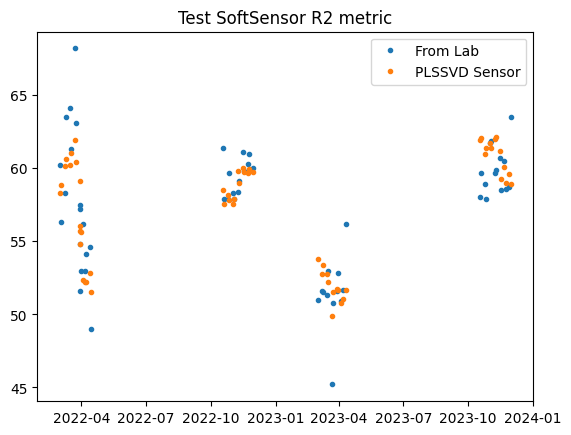

In [15]:
test_visual.visualize([Test_sensor_1])